Advantages;<br>
SVM Classifiers offer good accuracy and perform faster prediction compared to Naïve Bayes algorithm.<br>
They also use less memory because they use a subset of training points in the decision phase.<br>
SVM works well with a clear margin of separation and with high dimensional space.<br>

Disadvantages;<br>
SVM is not suitable for large datasets because of its high training time and it also takes more time in training compared to Naïve Bayes.<br>
It works poorly with overlapping classes and is also sensitive to the type of kernel used.

## Loading Data

In [1]:
import matplotlib.pyplot as plt 
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
#Loading the Dataframe from Feature_Extraction.ipynb
Dataset = pd.read_pickle("Data_te_norm.pkl")
Attack_label = pd.read_pickle("Attack_label.pkl")
Attack_type = pd.read_pickle("Attack_type.pkl")
Dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157800 entries, 0 to 157799
Data columns (total 36 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   arp.opcode              157800 non-null  float64
 1   arp.hw.size             157800 non-null  float64
 2   icmp.checksum           157800 non-null  float64
 3   icmp.seq_le             157800 non-null  float64
 4   http.content_length     157800 non-null  float64
 5   http.request.method     157800 non-null  float64
 6   http.referer            157800 non-null  float64
 7   http.request.version    157800 non-null  float64
 8   http.response           157800 non-null  float64
 9   tcp.ack                 157800 non-null  float64
 10  tcp.ack_raw             157800 non-null  float64
 11  tcp.checksum            157800 non-null  float64
 12  tcp.connection.fin      157800 non-null  float64
 13  tcp.connection.rst      157800 non-null  float64
 14  tcp.connection.syn  

## Relationship and Parameter estimation

<Axes: >

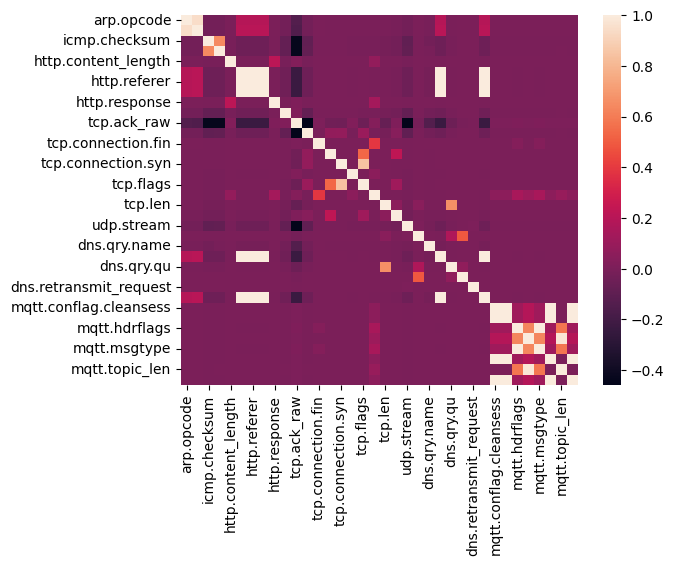

In [3]:
corr_Data = Dataset.corr(method="pearson") # the corr values shows that some Features are strongly correlated
sns.heatmap(corr_Data, annot=False)

* Pairplot(1); Features with negative Correlation Value below -0.3.

In [22]:
df = corr_Data.le(-0.3) # boolean Data
positions = np.array([]) 

for label, col in df.items(): # df.items is an iterator over columns
    for index, data in col.items(): # interation of each column gives index 
        if((data==True) & (index != label)):
                positions = np.append(arr= positions, values= [index], axis=0)

print(np.unique(positions))


['icmp.checksum' 'icmp.seq_le' 'tcp.ack_raw' 'tcp.checksum' 'udp.stream']


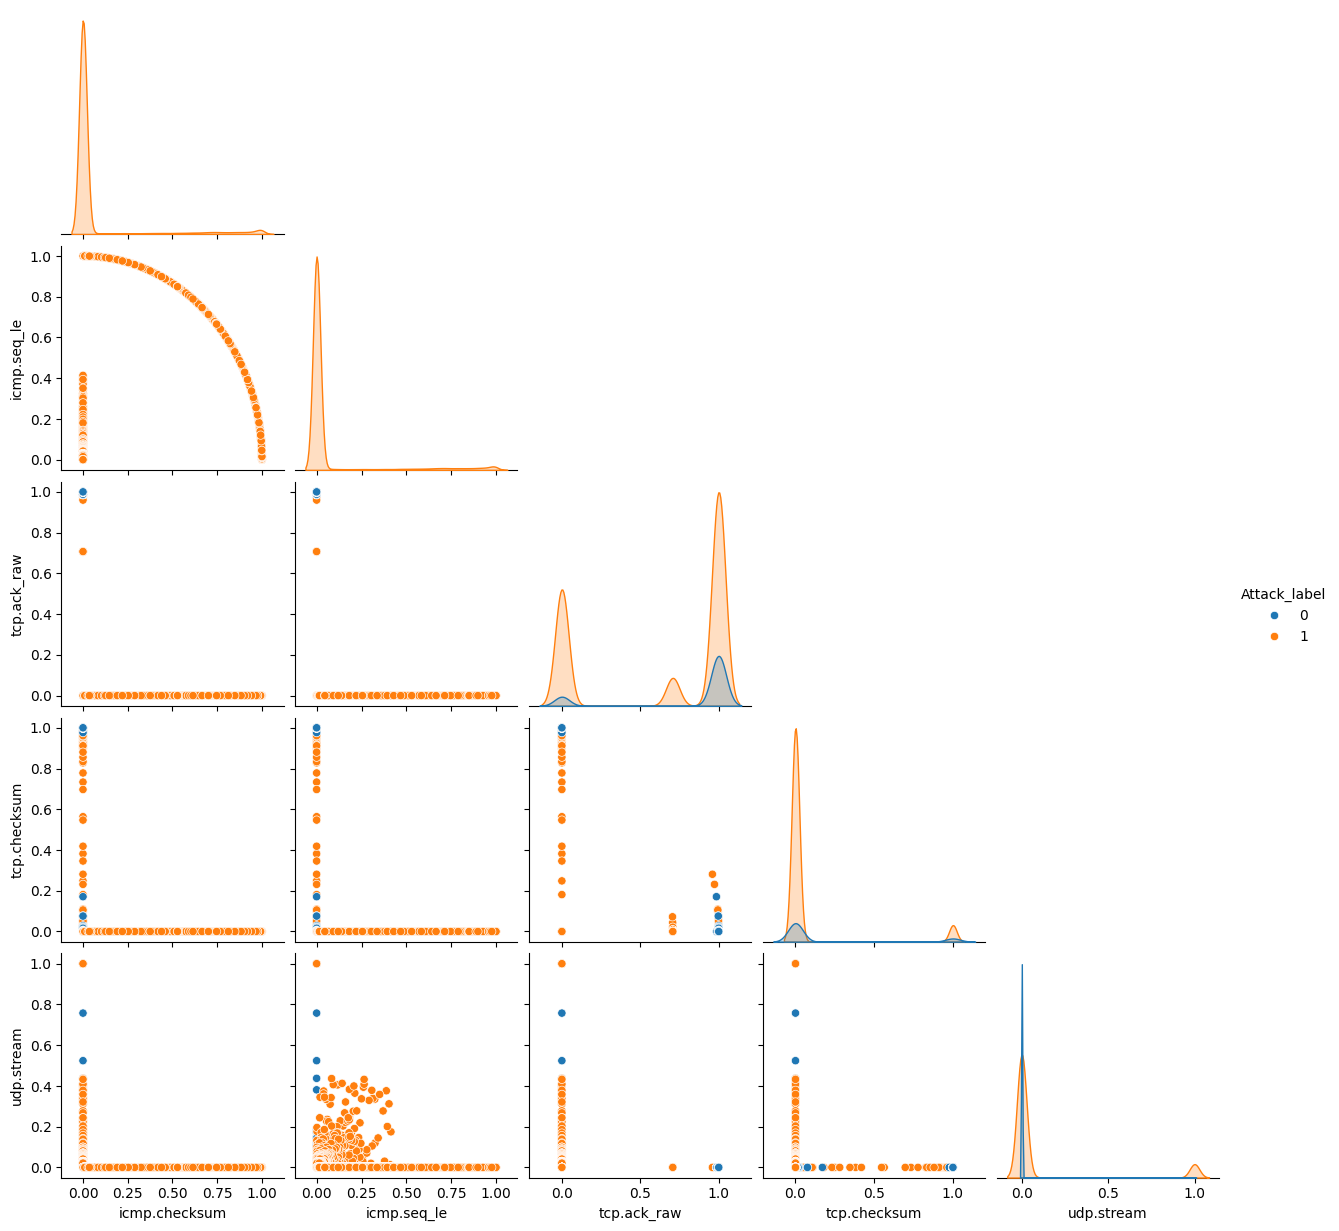

In [5]:
df = Dataset.join(Attack_label)
sns.pairplot(data= df, hue= 'Attack_label', vars= np.unique(positions), corner= True)

* Pairplot(2); Features with positive Correlation Value between 0.4 and 0.2.

In [4]:
df2 = (corr_Data.lt(0.4))==(corr_Data.gt(0.2)) # boolean Data
positions2 = np.array([]) 

for label, col in df2.items(): # df2.items is an iterator over columns
    for index, data in col.items(): # interation of each column gives index 
        if((data==True) & (index != label)):
                positions2 = np.append(arr= positions2, values= [index], axis=0)

print(np.unique(positions2))

['arp.hw.size' 'dns.qry.name.len' 'http.content_length' 'http.referer'
 'http.request.method' 'http.request.version' 'http.response'
 'mqtt.conack.flags' 'tcp.connection.fin' 'tcp.connection.rst'
 'tcp.flags.ack' 'tcp.seq']


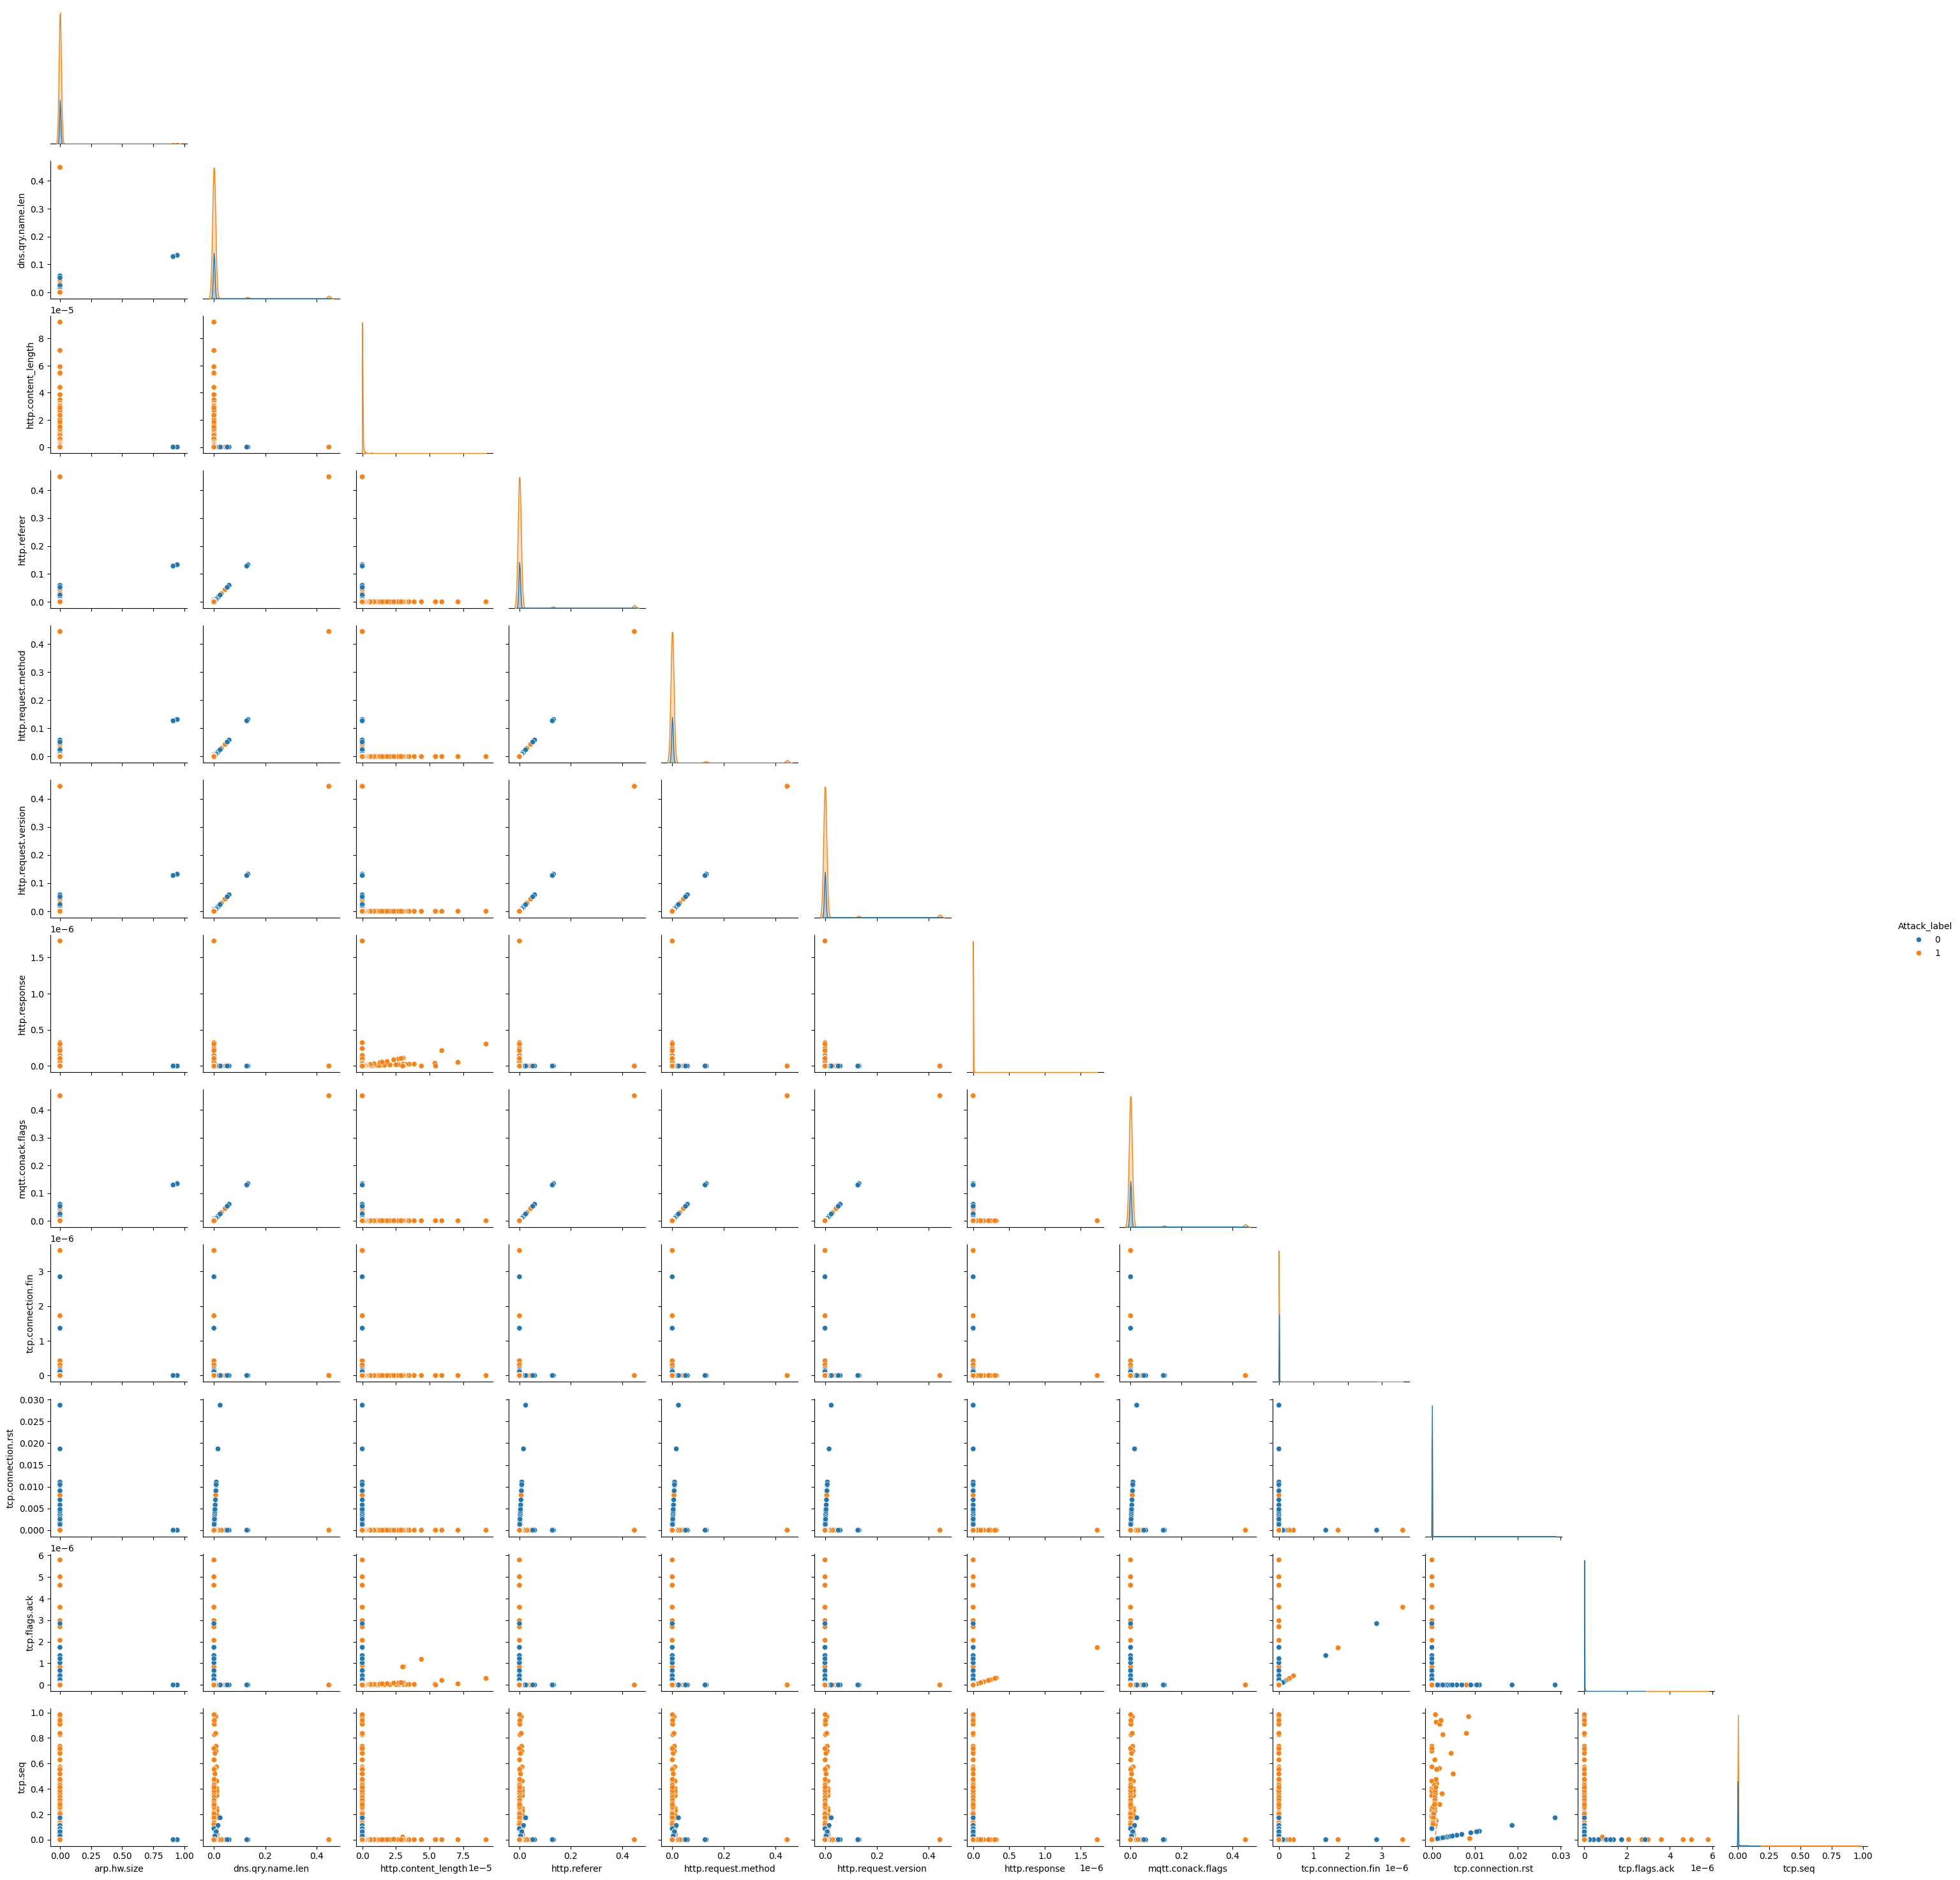

In [5]:
df2 = Dataset.join(Attack_label)
sns.pairplot(data= df2, hue= 'Attack_label', vars= np.unique(positions2), corner= True)

From the Graphs (Pairplots) it is evident that the Features **cannot** be seperated from each other by a hyperplane.
Hence a kernel is needed.

***

## Sampling the Dataset

In [4]:
# Working with smaller Dataset first
from sklearn.utils.random import sample_without_replacement
indices = sample_without_replacement(Dataset.shape[0],Dataset.shape[0]/8 , random_state=22)
Dataset_sampled = pd.DataFrame(Dataset.loc[indices.tolist()])
Attack_label_sampled = pd.DataFrame(Attack_label.loc[indices.tolist()])
Attack_type_sampled = pd.DataFrame(Attack_type.loc[indices.tolist()])

In [79]:
# Checking distribution before and after sampling
print("Before sampling: ", Attack_label.value_counts(normalize=True))
print("After sampling: ", Attack_label_sampled.value_counts(normalize=True))

Before sampling:  Attack_label
1    0.846001
0    0.153999
Name: proportion, dtype: float64
After sampling:  Attack_label
1               0.847909
0               0.152091
Name: proportion, dtype: float64


In [5]:
X = Dataset_sampled.to_numpy()
Yl = Attack_label_sampled.to_numpy(dtype='int')
#Yt = Attack_type.to_numpy(dtype= 'str')

## Train Test split

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.5, random_state=22)

## Hyperparameter

Deciding Parameters are Kernel and C. (if 'poly' kernel also d = degree)

In [8]:
from sklearn import svm
svm.SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

Random Search

In [10]:
from sklearn.model_selection import RandomizedSearchCV
svc = svm.SVC()
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[100, 120, 130, 140, 150]} # parameter grid
rand_eval = RandomizedSearchCV(svc, parameters, cv=2)
search = rand_eval.fit(X_train, Y_train)

print("Hyperparameters: ", search.best_params_)
print("Best score: ", search.best_score_)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

Hyperparameters:  {'kernel': 'poly', 'C': 120}
Best score:  0.8685864936118435


Grid Search

In [11]:
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':('linear', 'rbf', 'poly'), 'C':[150, 200, 500],}
svc = svm.SVC()
grid_eval = GridSearchCV(svc, parameters, cv=2)
search_grid = grid_eval.fit(X_train,Y_train)

print("Hyperparameters: ", search_grid.best_params_)
print("Best score: ", search_grid.best_score_)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

Hyperparameters:  {'C': 500, 'kernel': 'poly'}
Best score:  0.8690934901642668


Through searching Hyperparameters through Randomsearch and Gridsearch, it is evident that kernel as poly<br>
with a degree of 3 (default) and C of higher value is optimal.

In [42]:
from sklearn.model_selection import validation_curve
C_param = np.arange(1, 1e3, 100)
svc = svm.SVC(kernel='poly')
train_score, test_score = validation_curve(svc, X_train, Y_train, param_name= 'C', param_range= C_param, cv=2)


/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

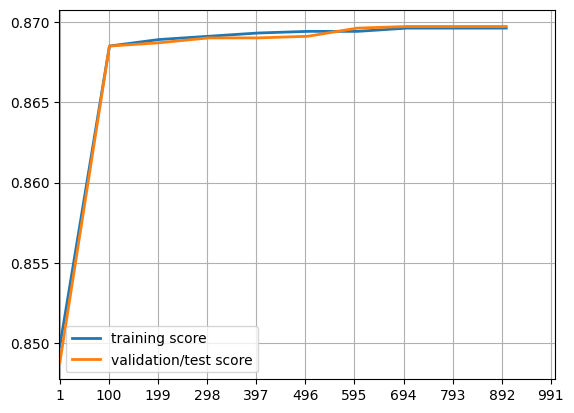

In [60]:
fig, ax = plt.subplots()
ax.grid()
ax.plot(C_param, train_score.mean(axis=1), linewidth=2.0, label = 'training score')
ax.plot(C_param, test_score.mean(axis=1), linewidth=2.0, label = 'validation/test score')
ax.set(xlim=(0, 1000), xticks=np.arange(1, 1000, 99))
plt.legend()
plt.show()

Through Validation_curve the maximum value of C is found to be 500 after which the test score precedes training score.<br>
So C=400 is concluded as Hyperparameter. <br>
Higher Value of C means low regularisation, smaller margin, strict classification.
Lower is opposite ofc.

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change t

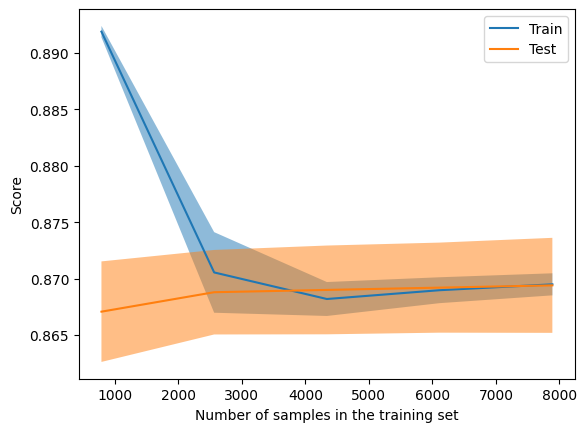

In [73]:
from sklearn.model_selection import LearningCurveDisplay, learning_curve
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.5, random_state=22)
svc = svm.SVC(kernel='poly', C=400)
train_sizes, train_scores, test_scores = learning_curve(svc, X_train, Y_train)
display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
display.plot()
plt.show()

For the given Hyperparameter (kernel = poly, degree = 3, C = 400) the model could be trained well enough from just<br>
around 3000 samples. 

## Modal SVC

In [91]:
X = Dataset_sampled.to_numpy() # 19725 sample
Yl = Attack_label_sampled.to_numpy(dtype='int')
# we need only around 3000 samples so test and training ratio can be only 0.2 and yet we get good result
X_train, X_test, Y_train, Y_test = train_test_split(X, Yl, test_size=0.8, random_state=22) 
svc = svm.SVC(kernel='poly', C=400)
clf = svc.fit(X_train, Y_train)
Y_pred = clf.predict(X_test)

/home/user/miniconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [92]:
X_train.shape

(3945, 36)

## Evaluation Metrics

Accuracy: 0.8711660329531052
Precision: 0.8681924273858921
Recall: 1.0
F1 Score: 0.929446468853028


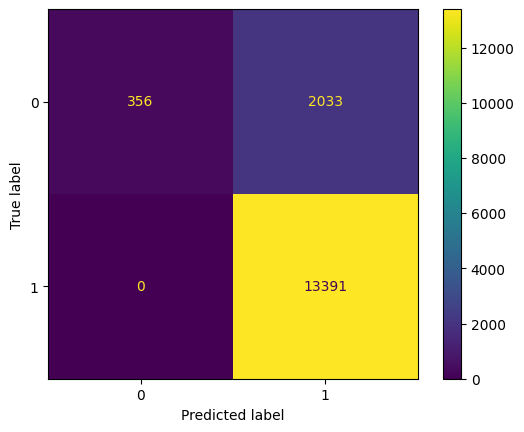

In [93]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

# Model Accuracy
print("Accuracy:",metrics.accuracy_score(Y_test, Y_pred))
# Model Precision
print("Precision:",metrics.precision_score(Y_test, Y_pred))
# Model Recall
print("Recall:",metrics.recall_score(Y_test, Y_pred))
# Model F1-Score
print("F1 Score:", metrics.f1_score(Y_test, Y_pred, average="binary"))

cm = metrics.confusion_matrix(Y_test, Y_pred, labels=clf.classes_)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()
plt.show()

## Conclusion

The Dataset is Loaded and sampled 1/8 of the original dataset with almost same distribution of labels, because for the<br>
SVM algorithm not too many samples are needed. Then with the help of these sampled dataset the modal is validated for<br>
Hyperparamters. With Random-Search and Grid-Search the Kernel for the modal is determined, which polynomial kernel with<br>
the degree of 3. Then with the help of validation-curve optimal value for the C parameter is found to be 400. Finally with linear_curve minimum number of samples to train a optimum modal is calculated. Which came to be around 3000 samples.<br>

The Final SVC modal which classifies from Normal to abnormal Dataflow has an accuracy rate of 87%. A striking <br>
result is that the false Negative is 0 for the modal which is trained with less samples than the number of test samples.<br>
**False negative = 0 means that the modal doesnt predict any abnormal dataflow as normal.** <br>
Hence this Modal can be a frontier for the final ensemble. 

Any dimension reduction ?
Multiclass classifier for types of attacks?
Linear SVC?
